In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms
from PIL import Image
import sys
from model import AggMInterface
from data import DInterface
import yaml
import numpy as np

# 定义可视化函数
def visualize_attention(image_tensor, attention_map, save_path=None, alpha=0.6):
    """
    可视化注意力图叠加到原始图像上
    Args:
        image_tensor: [3, H, W]
        attention_map: [num_heads, h, w]
        save_path: 保存路径
        alpha: 热图透明度，范围[0,1]
    """

    # 将注意力图上采样到原始图像大小
    attention_map = F.interpolate(
        attention_map.unsqueeze(0),
        size=image_tensor.shape[0:2],
        mode="bilinear",
        align_corners=False,
    )[0]

    # 处理原始图像
    if image_tensor.max() <= 1:
        image_tensor = image_tensor * 255
    image_np = image_tensor

    # 创建自定义热力图颜色映射（从透明到红色）
    colors = [(0, 0, 0, 0), (1, 0, 0, 1)]
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

    # 获取注意力头数量
    num_heads = attention_map.shape[0]

    # 计算行数和列数
    num_cols = min(6, num_heads)  # 每行最多6个
    num_rows = (num_heads + num_cols - 1) // num_cols  # 向上取整计算行数

    # 创建子图
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    if num_heads == 1:
        axes = np.array([axes])
    axes = axes.flatten()  # 将axes展平方便索引

    # 为每个注意力头创建叠加图
    for h in range(num_heads):
        # 显示原始图像
        axes[h].imshow(image_np)

        # 处理注意力图
        attn = attention_map[h].cpu()
        attn = (attn - attn.min()) / (attn.max() - attn.min())  # 归一化到[0,1]

        # 叠加热图
        axes[h].imshow(attn, cmap=cmap, alpha=alpha)
        axes[h].set_title(f"Attention Head {h}")
        axes[h].axis("off")

    # 隐藏多余的子图
    for h in range(num_heads, len(axes)):
        axes[h].axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        plt.show()


# 定义一个hook函数，获取多个层的输出
def get_layers_output(layers):
    outputs = {layer: [] for layer in layers}

    def hook(module, input, output, layer_name):
        outputs[layer_name].append(output)

    # 注册hook
    for layer in layers:
        layer.register_forward_hook(
            lambda module, input, output, layer_name=layer: hook(
                module, input, output, layer_name
            )
        )

    return outputs

正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


(560, 560, 3)
torch.Size([1, 3, 560, 560])


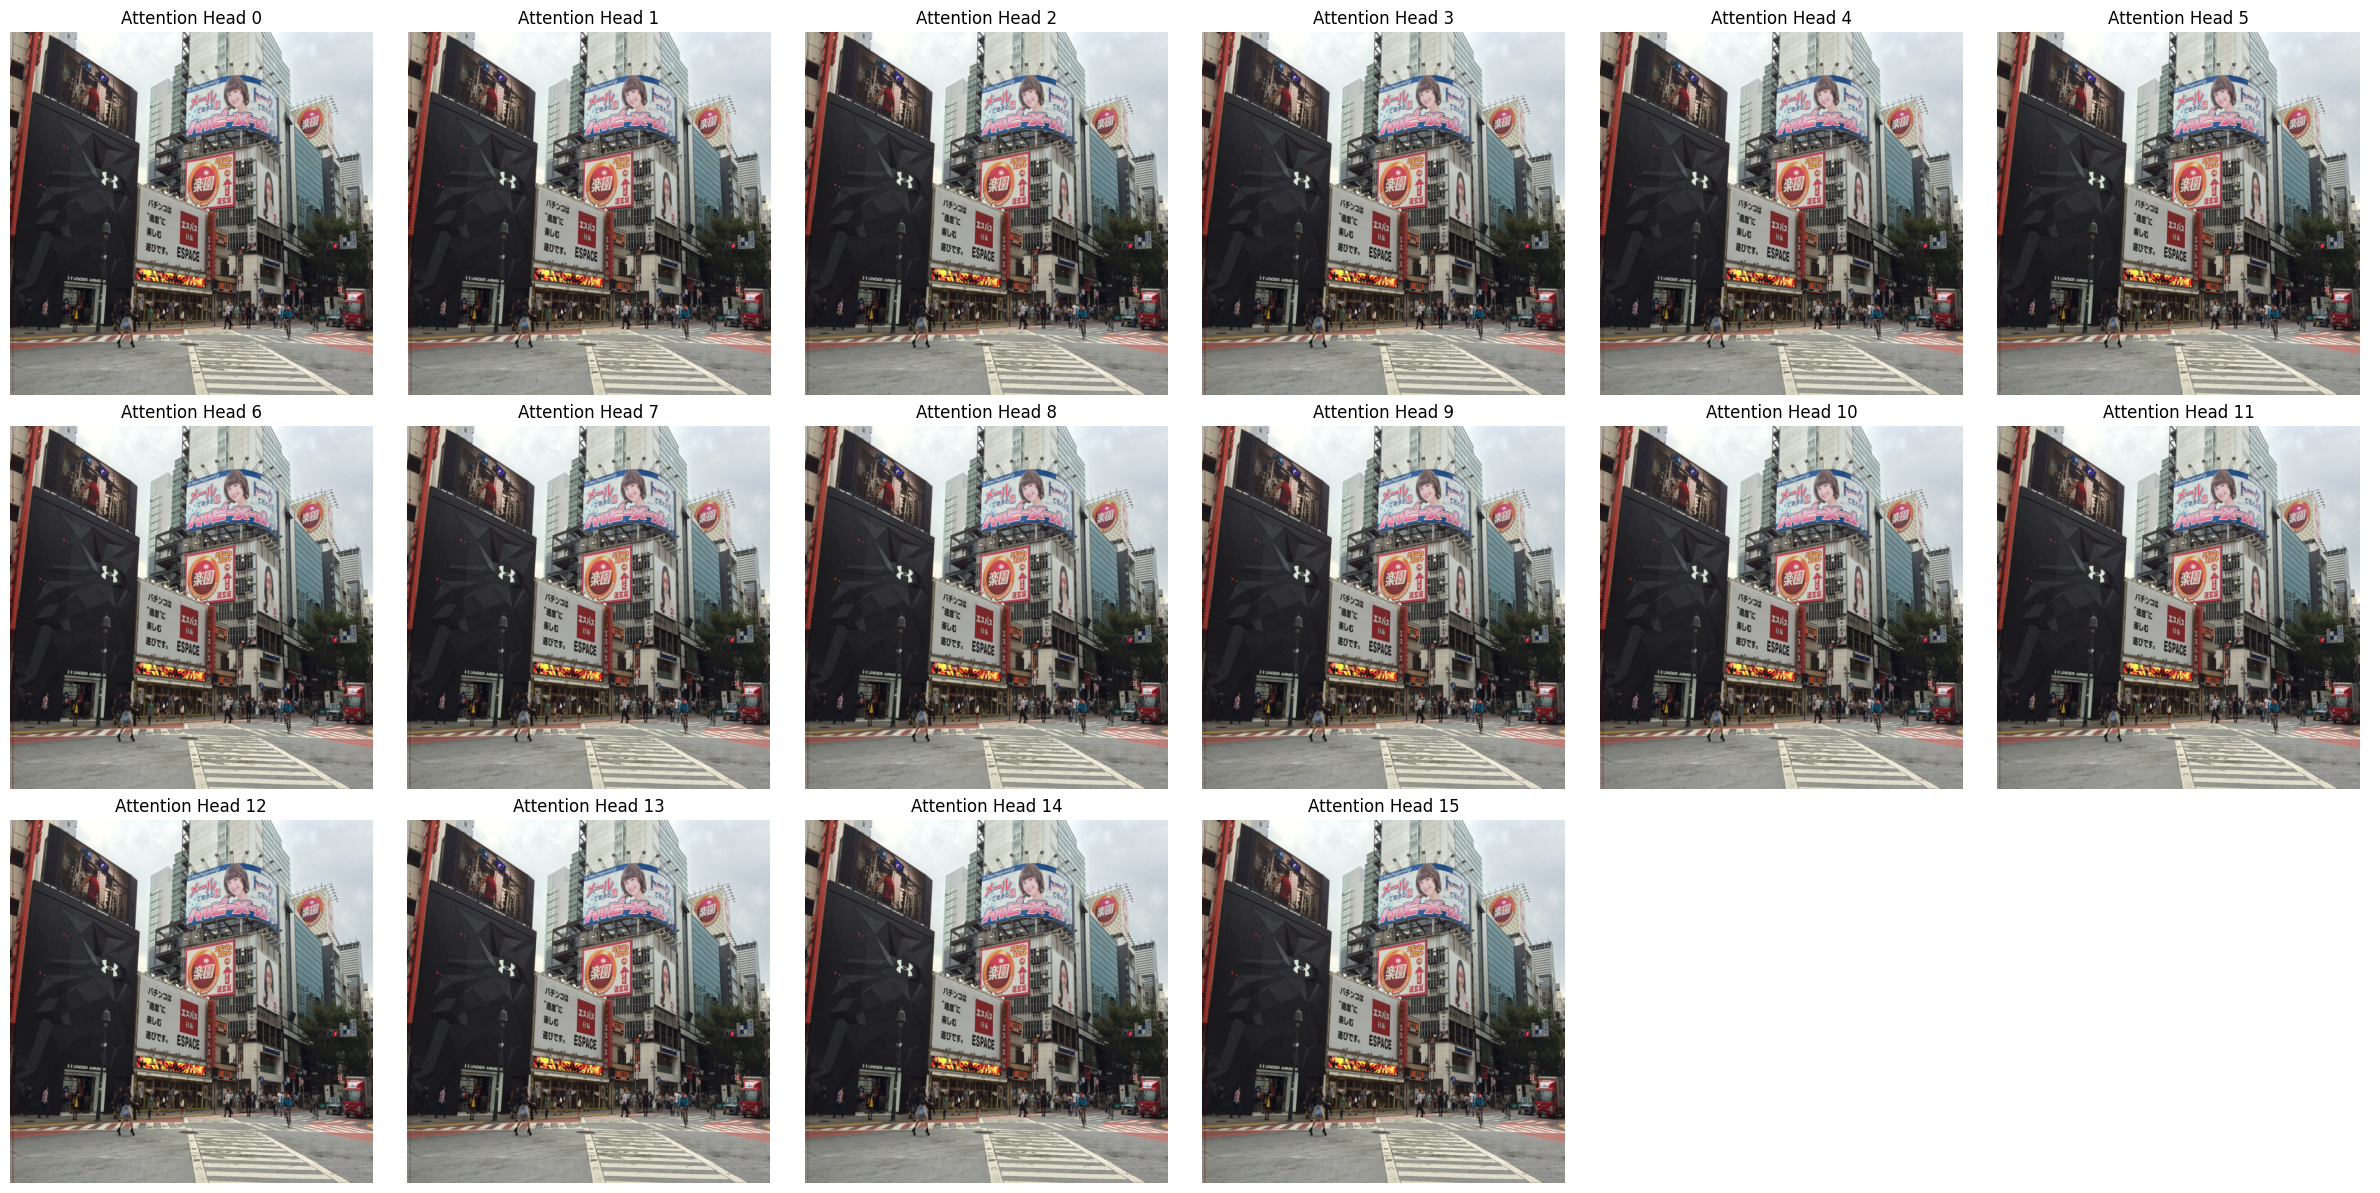

In [2]:
# 指定checkpoint和模型超参数
config_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_0/hparams.yaml"
checkpoint_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_0/checkpoints/dinov2_backbone_epoch(14)_step(14655)_R1[0.9149]_R5[0.9622]_R10[0.9703].ckpt"

# 加载yaml文件
with open(config_path) as f:
    config = yaml.safe_load(f)

# 初始化data moudle
data_module = DInterface(**config)  # 数据相关配置
transform = data_module.valid_transform  # val transform

# 初始化model
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()

# 注册hook
# 获取指定层的输出
layers_to_hook = [
    model.model.model.blocks[23].attn,
]
layers_output = get_layers_output(layers_to_hook)

# 获取指定图像的特征
image_path = r"/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/visualization/imgs/output_imgs/tokyo/00010.jpg"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image.resize((560, 560)))
print(image_np.shape)

x = transform(image).unsqueeze(0).cuda()
print(x.shape)

# 获取注意力图和特征, qkv来源于block_idx定义的层
cls_token, patch_tokens, (q, k, v) = model(x, is_training=False, block_idx=-1)

head_dim = 1024 // 16
scale = head_dim**-0.5
attn = q @ k.transpose(-2, -1)
attn = attn.softmax(dim=-1)
attn = attn[:, :, 1:, 1:]


# 可视化第一张图片的注意力图
visualize_attention(
    image_np,
    attn[0].detach().cpu(),
    save_path=None,
    alpha=0.6,
)
